# Анализатор текстовых пресс-релизов

Задача: На основании исторических пресс-релизов кредитных рейтинговых агентств участникам хакатона необходимо построить интерпретируемую ML-модель, устанавливающую взаимосвязь между текстом пресс-релиза и присвоенным кредитным рейтингом по национальной рейтинговой шкале Российской Федерации для организации с учетом методологических особенностей оценки рейтинга. ML-модель должна не просто устанавливать соответствие текста пресс-релиза кредитному рейтингу, но также и выделять ключевые конструкции в тексте, соответствующие присвоенному кредитному рейтингу.



## План

Исходя из поставленной зажачи мы сформировали план
1. Загрузить данные
2. Оценить данные, если нужно, почистить, лематизировать
3. Использовать для токенизации инструмент TfidfVectorizer
4. Построить на основе полученных векторов разные модели предсказания кредитного рейтинга
5. Оценить результаты и сделать выводы

In [164]:
import re
import json
from tqdm import tqdm, notebook
from nltk import word_tokenize
from nltk.corpus import wordnet, stopwords as nltk_stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from scipy.sparse import hstack
from tkinter import Tk, Button, Label, filedialog
from pandarallel import pandarallel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import joblib

tqdm.pandas()
pandarallel.initialize(progress_bar=True)


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [165]:
data = pd.read_excel('CRA_train_1200.xlsx')

In [167]:
data.head(5)

,Id,pr_txt,Категория,Уровень рейтинга
0,1,Повышение кредитного рейтинга Акционерного об...,A,A
1,2,«Эксперт РА» подтвердил кредитный рейтинг комп...,BB,BB
2,3,"НКР повысило кредитный рейтинг ООО ""ОТЭКО-Порт...",A,A
3,4,«Эксперт РА» присвоил кредитный рейтинг ПАО «Ф...,AAA,AAA
4,5,29 марта 2023 г. Ведущий рейтинговый аналитик ...,BBB,BBB


In [168]:
data = data.rename(columns={
    'pr_txt': 'text',
    'Категория': 'category',
    'Уровень рейтинга': 'rating'
})


In [159]:
# Замените на свой OAuth-токен
OAUTH_TOKEN = "?????????"

response = requests.post(
    "https://iam.api.cloud.yandex.net/iam/v1/tokens",
    data=json.dumps({"yandexPassportOauthToken": OAUTH_TOKEN}),
    headers={"Content-Type": "application/json"},
)

# Проверяем, что запрос прошел успешно
if response.status_code == 200:
    # Парсим ответ и извлекаем IAM-токен
    iam_token = response.json()["iamToken"]
    print("IAM-token успешно получен:")
    print(iam_token)
else:
    print(f"Не удалось получить IAM-token. Код ответа: {response.status_code}")
    print("Ответ сервера:")
    print(response.text)


IAM-token успешно получен:
t1.9euelZqRyMvMio2Zl5aVz5WTjpLMlO3rnpWajsuPjomPnpmWlcyLm4rKkZLl8_d0HApY-e8zOgw-_N3z9zRLB1j57zM6DD78zef1656VmpGakZnHj4mRm4yai8zMnMaY7_zF656VmpGakZnHj4mRm4yai8zMnMaY.2t_2rLJjyGpqvzNlQszcJMdz2vfXQ8kL0BWZQM6wAjkGm4tDYoqj5VwS3cnGIUvn6HM6v01EE1BQPZaE0LslCw


In [160]:
IAM_TOKEN = iam_token
folder_id = '?????'

def translate_texts(texts, target_language):
    body = {
        "targetLanguageCode": target_language,
        "texts": texts,
        "folderId": folder_id,
    }
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {IAM_TOKEN}"
    }
    
    response = requests.post('https://translate.api.cloud.yandex.net/translate/v2/translate', json=body, headers=headers)
    
    if response.status_code == 200:
        res_json = response.json()
        translated_texts = [text['text'] for text in res_json['translations']]
        return translated_texts
    else:
        print(f"Failed to translate texts. Status code: {response.status_code}")
        print("Response text:", response.text)
        return texts


# Создание нового датафрейма для хранения синтезированных данных
synthesized_data = pd.DataFrame(columns=['text', 'category', 'rating'])



for index, row in data.iterrows():
    # Начнем обработку с 65-го индекса
    if index < 65:
        continue

    original_text = row['text']
    print(index)
    # Проверка длины текста перед переводом
    if len(original_text) > 10000:
        original_text = original_text[:9000]
    
    translated_text_to_en = translate_texts([original_text], 'en')
    synthesized_text = translate_texts(translated_text_to_en, 'ru')
    
    # Добавление нового ряда в synthesized_data DataFrame
    new_row = {'text': synthesized_text[0], 'category': row['category'], 'rating': row['rating']}
    synthesized_data = pd.concat([synthesized_data, pd.DataFrame([new_row])], ignore_index=True)

# Сохраните новый датафрейм в файл CSV
synthesized_data.to_csv('synthesized_data.csv', index=False)




65
66
67
68
69
Failed to translate texts. Status code: 400
Response text: {
 "code": 3,
 "message": "total texts length must be not greater than 10000",
 "details": [
  {
   "@type": "type.googleapis.com/google.rpc.RequestInfo",
   "requestId": "4ac9d4b0-8422-4037-90b6-f9b48674bca5"
  }
 ]
}

70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
Failed to translate texts. Status code: 400
Response text: {
 "code": 3,
 "message": "total texts length must be not greater than 10000",
 "details": [
  {
   "@type": "type.googleapis.com/google.rpc.RequestInfo",
   "requestId": "1eff8e14-62f5-4849-86cb-04884493bbaf"
  }
 ]
}

107
108
109
Failed to translate texts. Status code: 400
Response text: {
 "code": 3,
 "message": "total texts length must be not greater than 10000",
 "details": [
  {
   "@type": "type.googleapis.com/google.rpc.RequestInfo",
   "requestId": "8bee82fa-15d1-4aed-b685-6d56db20c1f8"
  }
 ]
}

110
111
112
113
11

KeyboardInterrupt: 

In [169]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Zа-яА-Я ]+", "", text).strip()
    text = text.lower()
    return text

data['text'] = data['text'].apply(cleaning)

In [170]:
nltk_stopwords = list(nltk_stopwords.words('russian'))
extra_stopwords = [
        'далее', 'также', 'что', 'в', 'с', 'и', 'на', 'по', 'а', 'за', '—', 'как', 
    'у', 'до', 'средней', 'очень', 'один', 'это', 'средняя', '«', '»', '(', ')', 
    '№', '—', 'году', 'одной', 'посредством', 'ранее', 'большого', 'которая', 
    'который', 'этом', 'является', 'один', 'другой', 'доли', 'доля', 'их', 
    'которого', 'его', 'средний', 'средние', 'уровень', 'производителей', 
    'высокие', 'низкой', 'средней', 'продукции', 'компании', 'компания', 
    'продукция', 'оценка', 'оценки', 'оценку', 'показатели', 'показатель', 
    'факторы', 'фактор', 'уровня', 'профиля', 'бизнес', 'бизнеса', 'уровень', 
    'уровня', 'рейтинг', 'рейтинга', 'рейтингу', 'производства', 'производство'
]
nltk_stopwords.extend(extra_stopwords)
count_tf_idf = TfidfVectorizer(stop_words=nltk_stopwords)

def train_model(target_col):
    X = data['text']
    y = data[target_col].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

    tfidf_train = count_tf_idf.fit_transform(X_train)
    tfidf_test = count_tf_idf.transform(X_test)
    joblib.dump(count_tf_idf, 'tfidf_vectorizer.joblib')


    pipe = Pipeline([
        ('model', LogisticRegression(random_state=1, solver='liblinear', max_iter=200))
    ])

    param_grid = [

        {
            'model': [SVC(random_state=42)],
            'model__C': [10],
            'model__kernel': ['linear']
        },
    ]

    grid = GridSearchCV(pipe, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5, verbose=True, n_jobs=-1)
    best_grid = grid.fit(tfidf_train, y_train)
    
    print(f"Best parameters for {target_col} are:", grid.best_params_)
    print(f"Best cross-validation score for {target_col} is:", grid.best_score_)

    test_predictions = best_grid.predict(tfidf_test)
    test_score = f1_score(y_test, test_predictions, average='weighted')
    print(f"Test F1 score for {target_col} is:", test_score)
    joblib.dump(best_grid.best_estimator_, f'best_model_{target_col}.joblib')
    return grid.best_score_, test_score

category_cv_f1, category_test_f1 = train_model('category')

print(f"Final CV F1 score for 'category': {category_cv_f1}")
print(f"Final TEST F1 score for 'category': {category_test_f1}")

best_model = joblib.load('best_model_category.joblib')

tfidf_data = count_tf_idf.transform(data['text'])

data['category_pred'] = best_model.predict(tfidf_data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for category are: {'model': SVC(C=10, kernel='linear', random_state=42), 'model__C': 10, 'model__kernel': 'linear'}
Best cross-validation score for category is: 0.846522628907943
Test F1 score for category is: 0.8348874521453195
Final CV F1 score for 'category': 0.846522628907943
Final TEST F1 score for 'category': 0.8348874521453195


In [171]:
best_model = joblib.load('best_model_category.joblib')

feature_names = count_tf_idf.get_feature_names_out()

if isinstance(best_model.named_steps['model'], SVC) and best_model.named_steps['model'].kernel == 'linear':
    coefficients = best_model.named_steps['model'].coef_.toarray()

    top10_positive = coefficients[0].argsort()[-10:][::-1]
    top10_negative = coefficients[0].argsort()[:10]

    print("Top 10 positive features:")
    for j in top10_positive:
        print(f"{feature_names[j]} (coef: {coefficients[0][j]})")

    print("Top 10 negative features:")
    for j in top10_negative:
        print(f"{feature_names[j]} (coef: {coefficients[0][j]})")
else:
    print("Feature importance is not available for the current model.")


Top 10 positive features:
гмк (coef: 1.7824660054977604)
алюминия (coef: 1.5259437835491978)
ооо (coef: 1.4419992860988131)
никель (coef: 1.3657611941667651)
норильский (coef: 1.3657611941667651)
вэс (coef: 1.3343568826851007)
позитивный (coef: 1.096539563440496)
продаж (coef: 1.066507979455705)
гк (coef: 1.0633974730262497)
новотранс (coef: 1.0230395761354036)
Top 10 negative features:
aa (coef: -1.9155820644890404)
одк (coef: -1.5496270320098164)
распадская (coef: -1.5318400637440808)
россети (coef: -1.4845163643311607)
ростелеком (coef: -1.4322713795903474)
евразия (coef: -1.42292958615402)
силовые (coef: -1.347951815647642)
арктикгаз (coef: -1.332129090079528)
буровая (coef: -1.3213307544568098)
сетевая (coef: -1.2783631951492462)


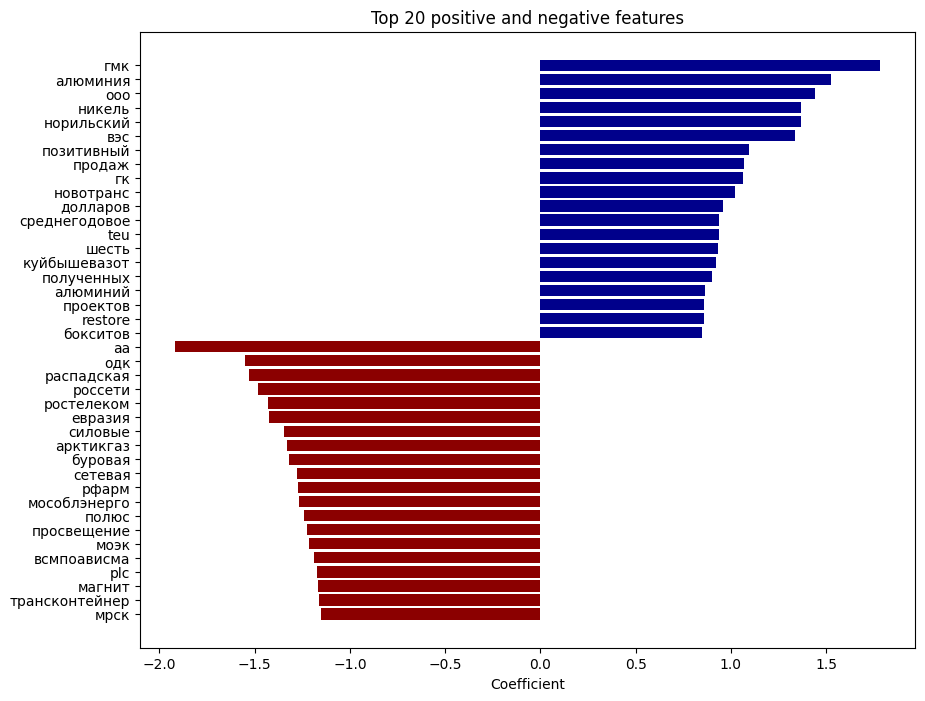

In [172]:
import matplotlib.pyplot as plt

best_model = joblib.load('best_model_category.joblib')

feature_names = count_tf_idf.get_feature_names_out()

if isinstance(best_model.named_steps['model'], SVC) and best_model.named_steps['model'].kernel == 'linear':
    coefficients = best_model.named_steps['model'].coef_.toarray()

    top30_positive = coefficients[0].argsort()[-20:][::-1]
    top30_negative = coefficients[0].argsort()[:20]

    top30_positive_features = [(feature_names[i], coefficients[0][i]) for i in top30_positive]
    top30_negative_features = [(feature_names[i], coefficients[0][i]) for i in top30_negative]

    features = top30_positive_features + top30_negative_features

    labels, vals = zip(*features)

    colors = ['darkblue' for _ in top30_positive_features] + ['darkred' for _ in top30_negative_features]

    plt.figure(figsize=(10, 8))
    y_pos = range(len(labels))
    plt.barh(y_pos, vals, color=colors)
    plt.yticks(y_pos, labels)
    plt.xlabel('Coefficient')
    plt.title('Top 20 positive and negative features')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Feature importance is not available for the current model.")


In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import stopwords

count_tf_idf = joblib.load('tfidf_vectorizer.joblib')

X_text_tfidf = count_tf_idf.transform(data['text'])

ohe = OneHotEncoder()
X_category_ohe = ohe.fit_transform(data[['category_pred']])

# Объединяем преобработанные признаки
from scipy.sparse import hstack
X = hstack([X_text_tfidf, X_category_ohe])

# Разделяем данные на тренировочные и тестовые наборы
y = data['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

model = SVC(C=10, kernel='linear', random_state=42)
model.fit(X_train, y_train)

# Оцениваем модель на тестовом наборе
y_pred = model.predict(X_test)
test_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f'Test F1 score: {test_f1_score}')

joblib.dump(model, 'model_rating.joblib')
joblib.dump(ohe, 'ohe_encoder.joblib')


Test F1 score: 0.8347826086956522


['ohe_encoder.joblib']

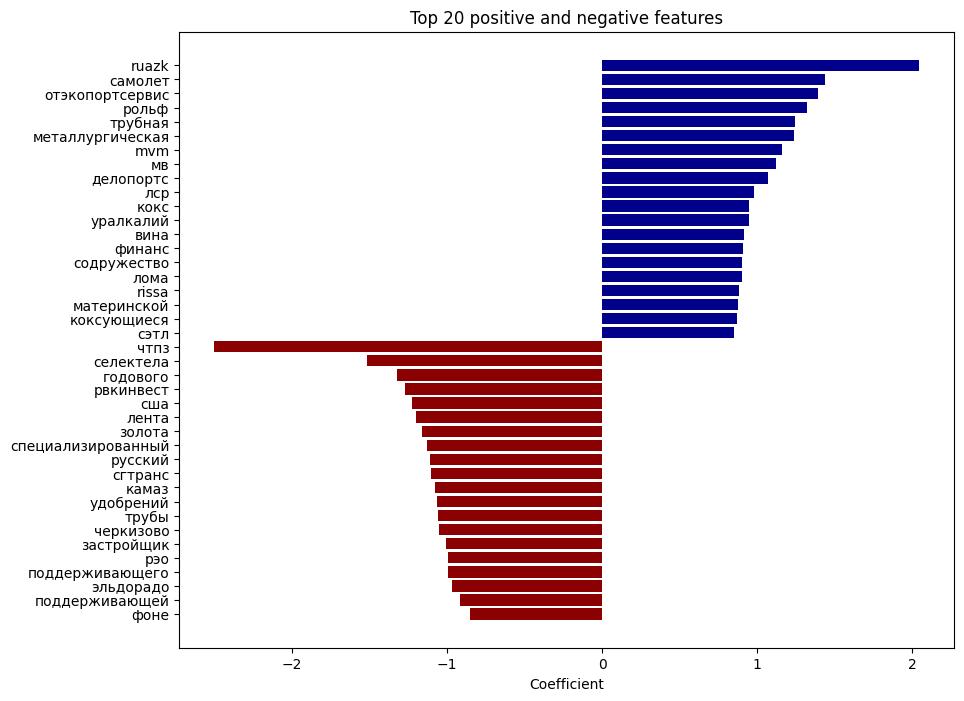

In [174]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# Применяем OneHotEncoder
ohe = OneHotEncoder()
X_category_ohe = ohe.fit_transform(data[['category_pred']])

# Получим названия признаков после OneHotEncoder
category_feature_names = ohe.get_feature_names_out(input_features=['category_pred'])

# Объединим все названия признаков
feature_names = count_tf_idf.get_feature_names_out().tolist() + category_feature_names.tolist()

model = joblib.load('model_rating.joblib')

coefficients = model.coef_.toarray()

top30_positive = coefficients[0].argsort()[-20:][::-1]
top30_negative = coefficients[0].argsort()[:20]

top30_positive_features = [(feature_names[i], coefficients[0][i]) for i in top30_positive]
top30_negative_features = [(feature_names[i], coefficients[0][i]) for i in top30_negative]

# Создадим график
features = top30_positive_features + top30_negative_features
labels, vals = zip(*features)

colors = ['darkblue' for _ in top30_positive_features] + ['darkred' for _ in top30_negative_features]

plt.figure(figsize=(10, 8))
y_pos = range(len(labels))
plt.barh(y_pos, vals, color=colors)
plt.yticks(y_pos, labels)
plt.xlabel('Coefficient')
plt.title('Top 20 positive and negative features')
plt.gca().invert_yaxis()
plt.show()


In [175]:
final_test_score = (test_f1_score * 0.65) + (category_test_f1 * 0.35) 
final_test_score

0.8348193039030358

In [176]:
data = pd.read_excel('CRA_test_422.xlsx')

def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Zа-яА-Я ]+", "", text).strip()
    text = text.lower()
    return text

data['pr_txt'] = data['pr_txt'].apply(cleaning)

count_tf_idf = joblib.load('tfidf_vectorizer.joblib')
X = data['pr_txt']
tfidf_data = count_tf_idf.transform(X)

best_model_category = joblib.load('best_model_category.joblib')
    
data['category_pred'] = best_model_category.predict(tfidf_data)



count_tf_idf = joblib.load('tfidf_vectorizer.joblib')

X_text_tfidf = count_tf_idf.transform(data['pr_txt'])

ohe = joblib.load('ohe_encoder.joblib')

X_category_ohe = ohe.transform(data[['category_pred']])

from scipy.sparse import hstack
X = hstack([X_text_tfidf, X_category_ohe])


model = joblib.load('model_rating.joblib')

data['Уровень рейтинга'] = model.predict(X)
data['Категория'] = data['category_pred']
data.drop(columns=['category_pred'], inplace=True) 
data[['Id','Категория','Уровень рейтинга']].to_csv('submission.csv', sep=';',  index=False)


In [142]:
from tkinter import Tk, Button, Label, filedialog
import pandas as pd
import joblib
import re
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Zа-яА-Я ]+", "", text).strip()
    text = text.lower()
    return text

def make_predictions():
    filepath = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
    
    if filepath:
        data = pd.read_excel(filepath)

        data['pr_txt'] = data['pr_txt'].apply(cleaning)

        count_tf_idf = joblib.load('tfidf_vectorizer.joblib')
        X = data['pr_txt']
        tfidf_data = count_tf_idf.transform(X)

        best_model_category = joblib.load('best_model_category.joblib')
        data['category_pred'] = best_model_category.predict(tfidf_data)

        X_text_tfidf = count_tf_idf.transform(data['pr_txt'])

        ohe = joblib.load('ohe_encoder.joblib')
        X_category_ohe = ohe.transform(data[['category_pred']])

        X = hstack([X_text_tfidf, X_category_ohe])

        model = joblib.load('model_rating.joblib')
        data['Уровень рейтинга'] = model.predict(X)
        
        data['Категория'] = data['category_pred']
        data.drop(columns=['category_pred'], inplace=True)
        
        output_filepath = filepath.replace(".xlsx", "_predictions.csv")
        data[['Id','Категория','Уровень рейтинга']].to_csv(output_filepath, sep=';', index=False)
        
        label.config(text="Предсказание выполнено!")

root = Tk()
root.title("Предсказание категории и уровня рейтинга")

btn = Button(root, text="Загрузите файл для предсказания", command=make_predictions)
btn.pack(pady=20)

label = Label(root, text="")
label.pack(pady=20)

root.mainloop()
